# Encontro 13: Medidas de Centralidade

Importando a biblioteca:

In [3]:
import sys
sys.path.append('..')

from random import choice
import pandas as pd
from itertools import permutations
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import socnet as sn

Configurando a biblioteca:

In [4]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

Carregando rede de casamentos entre famílias de Florença durante a Renascença.

J. F. Padgett e C. K. Ansell. *Robust action and the rise of the Medici, 1400–1434.* American Journal of
Sociology 98, págs. 1259-1319, 1993.

In [5]:
g = sn.load_graph('Renaissance.gml', has_pos=True)

sn.show_graph(g, nlab=True)

Função que registra, em cada nó, seus sucessores em geodésicas de $s$ a $t$.

ps: Geodésica é o menor caminho possível que liga dois nós em um grafo.

In [6]:
def set_geodesic_successors(g, s, t):
    for n in g.nodes:
        g.nodes[n]['geodesic_successors'] = set()

    for p in nx.all_shortest_paths(g, s, t):
        for i in range(len(p) - 1):
            g.nodes[p[i]]['geodesic_successors'].add(p[i + 1])

Funções que representam uma escolha aleatória de sucessor para diferentes tipos de trajetórias.

In [7]:
# Pense que o atributo 'passages' abaixo indica quantas
# vezes um fluxo já passou por um nó ou por uma aresta.

def random_geodesic_successor(g, n):
    return choice([m for m in g.nodes[n]['geodesic_successors']])

def random_path_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.nodes[m]['passages'] == 0])

def random_trail_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.edges[n, m]['passages'] == 0])

def random_walk_successor(g, n):
    return choice([m for m in g.neighbors(n)])

Função que faz uma simulação de fluxo de $s$ a $t$, que pode ou não ser bem-sucedida.

In [8]:
def simulate_single_flow(g, s, t, sucessor_type, diffusion_type):
    # Inicializa o atributo 'passages' de cada nó.
    for n in g.nodes:
        g.nodes[n]['passages'] = 0
    g.nodes[s]['passages'] = 1

    # Inicializa o atributo 'passages' de cada aresta.
    for n, m in g.edges:
        g.edges[n, m]['passages'] = 0

    # Inicializa s como o único dono do insumo.
    for n in g.nodes:
        g.nodes[n]['owner'] = False
    g.nodes[s]['owner'] = True

    # Simula o fluxo, contando o número total de passos.

    steps = 0

    while True:
        # O conjunto reached representa todos os nós
        # que o fluxo consegue alcançar no passo atual.
        reached = set()

        # Verifica cada um dos donos atuais do insumo.

        owners = [n for n in g.nodes if g.nodes[n]['owner']]

        for n in owners:
            # Escolhe aleatoriamente um dos sucessores.
            try:
                if sucessor_type == "geodesic":
                    m = random_geodesic_successor(g, n)
                    
                if sucessor_type == "path":
                    m = random_path_successor(g, n)
                    
                if sucessor_type == "trail":
                    m = random_trail_successor(g, n)
                    
                if sucessor_type == "walk":
                    m = random_walk_successor(g, n)
                    
            except IndexError:
                continue

            if diffusion_type == "duplication":
                # Continua a ser dono do insumo.
                g.nodes[n]['owner'] = True
            if diffusion_type == "transfer":
                # Deixa de ser dono do insumo.
                g.nodes[n]['owner'] = False
                
            # Incrementa o atributo 'passages' do nó.
            g.nodes[m]['passages'] += 1

            # Incrementa o atributo 'passages' da aresta.
            g.edges[n, m]['passages'] += 1

            # Registra que consegue alcançar esse nó.
            reached.add(m)

        # Todo nó alcançado passa a ser dono do insumo.

        for n in reached:
            g.nodes[n]['owner'] = True

        # Isso conclui o passo atual da simulação.
        steps += 1

        # Se o passo alcançou t, chegamos ao fim da simulação.
        # Ela foi bem-sucedida: devolvemos o número de passos.
        if t in reached:
            return steps

        # Se o passo não alcançou ninguém, chegamos ao fim da
        # simulação. Ela não foi bem-sucedida: devolvemos -1.
        if not reached:
            return -1

Função que faz simulações de fluxo de $s$ a $t$ até uma ser bem-sucedida.

In [9]:
def simulate_successful_flow(g, s, t, sucessor_type, diffusion_type):
    set_geodesic_successors(g, s, t)

    while True:
        steps = simulate_single_flow(g, s, t, sucessor_type, diffusion_type)

        if steps != -1:
            return steps

Função que faz simulações de fluxo para todo $s$ e $t$ possíveis, e tira disso um *closeness simulado* e um *betweenness simulado*.

In [10]:
def simulate_all_flows(g, sucessor_type, diffusion_type):
    for n in g.nodes:
        g.nodes[n]['closeness'] = 0
        g.nodes[n]['betweenness'] = 0

    for s, t in permutations(g.nodes, 2):
        steps = simulate_successful_flow(g, s, t, sucessor_type, diffusion_type)

        g.nodes[s]['closeness'] += steps
        for n in g.nodes:
            if n != s and n != t:
                g.nodes[n]['betweenness'] += g.nodes[n]['passages']

    # Normalizações necessárias para comparar com os
    # resultados analíticos. Não é preciso entender.
    for n in g.nodes:
        g.nodes[n]['closeness'] = (g.number_of_nodes() - 1) / g.nodes[n]['closeness']
        g.nodes[n]['betweenness'] /= (g.number_of_nodes() - 1) * (g.number_of_nodes() - 2)

Média de *closeness simulado* e *betweenness simulado* para muitas repetições da simulação acima.

In [11]:
TIMES = 100

sucessor_type = ["geodesic", "path", "trail", "walk"]
diffusion_type = ["transfer", "duplication"]

for n in g.nodes:
    g.nodes[n]['mean_closeness'] = 0
    g.nodes[n]['mean_betweenness'] = 0

for _ in range(TIMES):
    simulate_all_flows(g, sucessor_type[0], diffusion_type[1])

    for n in g.nodes:
        g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
        g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']

for n in g.nodes:
    g.nodes[n]['mean_closeness'] /= TIMES
    g.nodes[n]['mean_betweenness'] /= TIMES

Cálculo de *closeness* e *betweenness* a partir das funções prontas da NetworkX, para comparação.

In [12]:
cc = nx.closeness_centrality(g)
bc = nx.betweenness_centrality(g)

Construção de data frame só para comparar mais facilmente.

In [13]:
pd.DataFrame({
    'família': [g.nodes[n]['label'] for n in g.nodes],
    'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
    'closeness analítico': [cc[n] for n in g.nodes],
    'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
    'betweenness analítico': [bc[n] for n in g.nodes],
})

,família,closeness simulado,closeness analítico,betweenness simulado,betweenness analítico
0,ginori,0.333333,0.333333,0.000000,0.000000
1,lambertes,0.325581,0.325581,0.000000,0.000000
2,albizzi,0.482759,0.482759,0.572527,0.212454
3,guadagni,0.466667,0.466667,0.691593,0.260073
4,pazzi,0.285714,0.285714,0.000000,0.000000
5,salviati,0.388889,0.388889,0.406593,0.142857
6,medici,0.560000,0.560000,1.390604,0.521978
7,tornabuon,0.482759,0.482759,0.245275,0.091575
8,bischeri,0.400000,0.400000,0.313462,0.120879
9,ridolfi,0.482759,0.482759,0.247033,0.086081


E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

In [14]:
TIMES = 100

sucessor_type = ["geodesic", "path", "trail", "walk"]
diffusion_type = ["transfer", "duplication"]
data_list = []
w = sn.load_graph('Renaissance.gml', has_pos=True)

for t in diffusion_type:
    for i in sucessor_type:
        g = w.copy()
        for n in g.nodes:
            g.nodes[n]['mean_closeness'] = 0
            g.nodes[n]['mean_betweenness'] = 0

        for _ in range(TIMES):
            simulate_all_flows(g, sucessor_type[sucessor_type.index(i)], diffusion_type[diffusion_type.index(t)])

            for n in g.nodes:
                g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
                g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']

        for n in g.nodes:
            g.nodes[n]['mean_closeness'] /= TIMES
            g.nodes[n]['mean_betweenness'] /= TIMES

        cc = nx.closeness_centrality(g)

        bc = nx.betweenness_centrality(g)

        data = pd.DataFrame({
            'família': [g.nodes[n]['label'] for n in g.nodes],
            'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
            'closeness analítico': [cc[n] for n in g.nodes],
            'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
            'betweenness analítico': [bc[n] for n in g.nodes],
            'sucessor type': i,
            'diffusion_type': t
        })

        data.name = i
        data_list.append(data)

In [15]:
result = pd.concat(data_list, ignore_index=True)

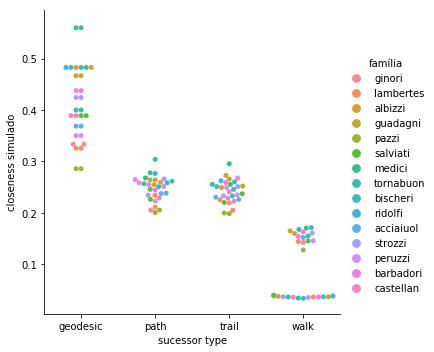

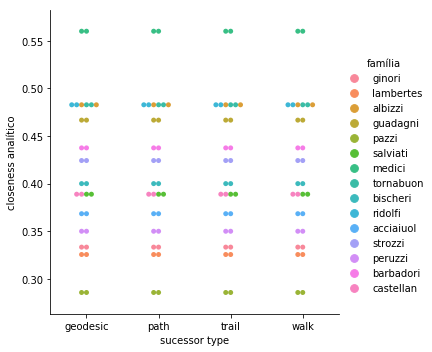

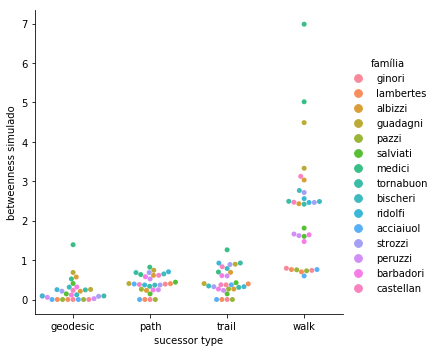

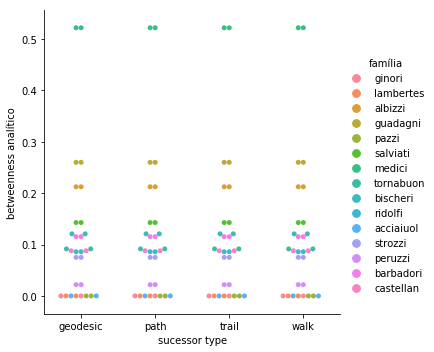

In [16]:
def plot_hist(rel1, rel2):
    sns.catplot(x=rel1, y=rel2, hue="família", kind="swarm", data=result)
    
plot_hist("sucessor type", "closeness simulado")
plot_hist("sucessor type", "closeness analítico")
plot_hist("sucessor type", "betweenness simulado")
plot_hist("sucessor type", "betweenness analítico")

In [30]:
result[["família", "closeness simulado", "closeness analítico", "sucessor type", "diffusion_type"]].sort_values(by=['closeness simulado'], ascending=False)

,família,closeness simulado,closeness analítico,sucessor type,diffusion_type
66,medici,0.560000,0.560000,geodesic,duplication
6,medici,0.560000,0.560000,geodesic,transfer
67,tornabuon,0.482759,0.482759,geodesic,duplication
9,ridolfi,0.482759,0.482759,geodesic,transfer
2,albizzi,0.482759,0.482759,geodesic,transfer
69,ridolfi,0.482759,0.482759,geodesic,duplication
62,albizzi,0.482759,0.482759,geodesic,duplication
7,tornabuon,0.482759,0.482759,geodesic,transfer
63,guadagni,0.466667,0.466667,geodesic,duplication
3,guadagni,0.466667,0.466667,geodesic,transfer


In [18]:
result[["família", "betweenness simulado", "betweenness analítico", "sucessor type", "diffusion_type"]].sort_values(by=['betweenness simulado'], ascending=False)

,família,betweenness simulado,betweenness analítico,sucessor type,diffusion_type
111,medici,6.984670,0.521978,walk,duplication
51,medici,5.016264,0.521978,walk,transfer
108,guadagni,4.487308,0.260073,walk,duplication
48,guadagni,3.329780,0.260073,walk,transfer
119,castellan,3.124341,0.087912,walk,duplication
107,albizzi,3.032088,0.212454,walk,duplication
113,bischeri,2.765220,0.120879,walk,duplication
116,strozzi,2.714725,0.075092,walk,duplication
114,ridolfi,2.559121,0.086081,walk,duplication
52,tornabuon,2.491209,0.091575,walk,transfer


Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior closeness simulado e betweenness simulado não são necessariamente os nós com maior closeness e betweenness segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

    Em outros tipos de trajetória e difusão, os nós com maior closeness simulado e betweeness simulado NÃO são NECESSÁRIAMENTE os nós com maior closeness e betweennes segundos o trajeto de geodésica e transferência.

Na tabela 1, onde o closeness simulado está ordenado na ordem descrescente, temos que os maiores closeness simulado  das famílias 